# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)


**Question** how to treat sampling values when input is not time

---

Inflation data 
https://data.oecd.org/price/inflation-cpi.htm

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

## Load dataset

In [3]:
df = pd.read_csv('data/finance_datasets/currency_exchange/final_dataset.csv')
cols = list(df)[3:]
cols[0], cols[1] = cols[1], cols[0]
cols

['EUR/USD',
 'CAD/USD',
 'JPY/USD',
 'GBP/USD',
 'CHF/USD',
 'AUD/USD',
 'HKD/USD',
 'NZD/USD',
 'KRW/USD',
 'MXN/USD']

In [4]:
data = []
for c in cols:
    data.append(mogptk.LoadCSV('data/finance_datasets/currency_exchange/final_dataset.csv',
                               x_cols='Day',
                               y_col=c,
                               name=c))
for d in data:
    d.transform(mogptk.TransformDetrend)

## Create and fit model

Remove data to simulate sensor failure

In [5]:
# randomly sample from the data
for channel in data:
    channel.remove_randomly(pct=0.3)

# drop chunks to simulate sensor failure

data[0].remove_range(df['Day'].iloc[-1], None)
data[1].remove_range(90, 120)
data[2].remove_range(480, 520)
data[3].remove_range(200, 250)
data[4].remove_range(None, 30)
data[5].remove_range(None, 30)
data[7].remove_range(500, 550)

for i in range(1, len(cols)):
     data[i].remove_range(650, None)

# add pred values

# use data class
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df[cols[i]].values[~data[i].mask] for i in range(len(cols))]

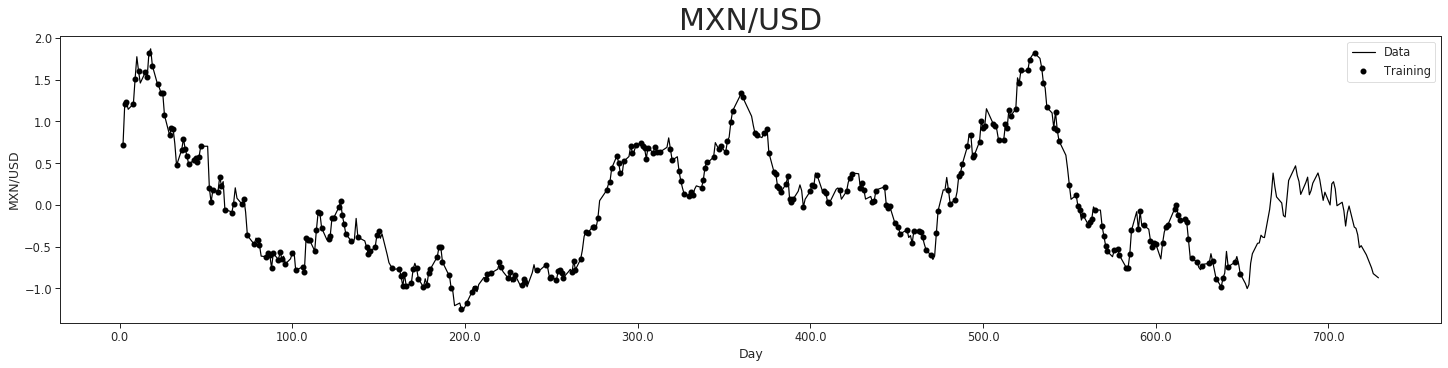

In [15]:
i = 9
data[i].plot()

## MOSM

warning!!!, long time of execution

In [16]:
n_trials = 5

mosm_mae = np.zeros((n_trials, len(cols)))
mosm_mape = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=5)
    model_mosm.init_params('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    print('Finished trial', n)
    print('='*50)        
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_mape[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -7249.302142
  Number of iterations: 5000
  Number of functions evaluations: 5390
Done in  124.9519038438797  minutes
Finished trial 0
Starting trial 1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -7197.257764
  Number of iterations: 5000
  Number of functions evaluations: 5343
Done in  124.57902012268703  minutes
Finished trial 1
Starting trial 2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -7182.602262
  Number of iterations: 5000
  Number of functions evaluations: 5327
Done in  124.59821306069692  minutes
Finished trial 2
Starting trial 3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function valu

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.002377,0.273194,0.003056,0.000094,0.010918,0.000134
1,0.007958,0.603608,0.012524,0.001169,0.089323,0.001757
2,0.746066,0.668347,1.071438,0.138930,0.122315,0.214423
3,0.005845,0.755940,0.008345,0.000431,0.054542,0.000709
4,0.004636,0.465857,0.007250,0.000550,0.054690,0.001553
5,0.009604,0.704919,0.015637,0.001004,0.072793,0.002636
6,0.005206,0.066557,0.009094,0.001305,0.016676,0.002001
7,0.015955,1.095807,0.025899,0.003428,0.233263,0.006849
8,4.992637,0.444221,6.983970,0.490095,0.042964,0.887820
9,0.155442,0.788906,0.241719,0.048775,0.240785,0.092052


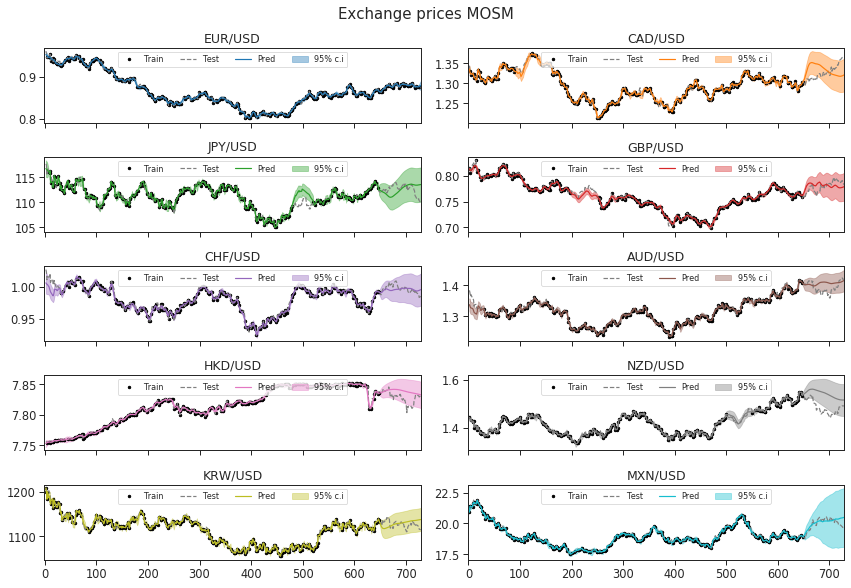

In [202]:
mogptk.plot_prediction(model_mosm, grid=(5, 2), names=cols, title='Exchange prices MOSM');
plt.savefig('output/mosm_exchange_rate.pdf', bbox_inches='tight')

## CSM

In [52]:
n_trials = 5

csm_mae = np.zeros((n_trials, len(cols)))
csm_mape = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=5)
    model_csm.init_params('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=5000, tol=1e-15)
    print('Finished trial', n)
    print('='*50)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_mape[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -4934.538008
  Number of iterations: 5000
  Number of functions evaluations: 5460
Done in  96.06577033599218  minutes
Finished trial 0
Starting trial 1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -4930.838936
  Number of iterations: 5000
  Number of functions evaluations: 5495
Done in  95.66676566203435  minutes
Finished trial 1
Starting trial 2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -4958.266824
  Number of iterations: 5000
  Number of functions evaluations: 5541
Done in  97.75475840568542  minutes
Finished trial 2
Starting trial 3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value:

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.005344,0.614186,0.006907,0.000106,0.013249,0.000064
1,0.011625,0.884632,0.015807,0.000115,0.008990,0.000105
2,0.768309,0.691441,1.033004,0.004397,0.003942,0.003864
3,0.008799,1.148961,0.011339,0.000069,0.008883,0.000036
4,0.007078,0.723617,0.009509,0.000048,0.004856,0.000055
5,0.012989,0.960454,0.016145,0.000067,0.004921,0.000089
6,0.007242,0.092634,0.008916,0.000060,0.000769,0.000112
7,0.017427,1.205096,0.021824,0.000307,0.021271,0.000259
8,5.037526,0.449931,6.749795,0.048198,0.004246,0.185885
9,0.179077,0.929440,0.246589,0.007248,0.038471,0.009487


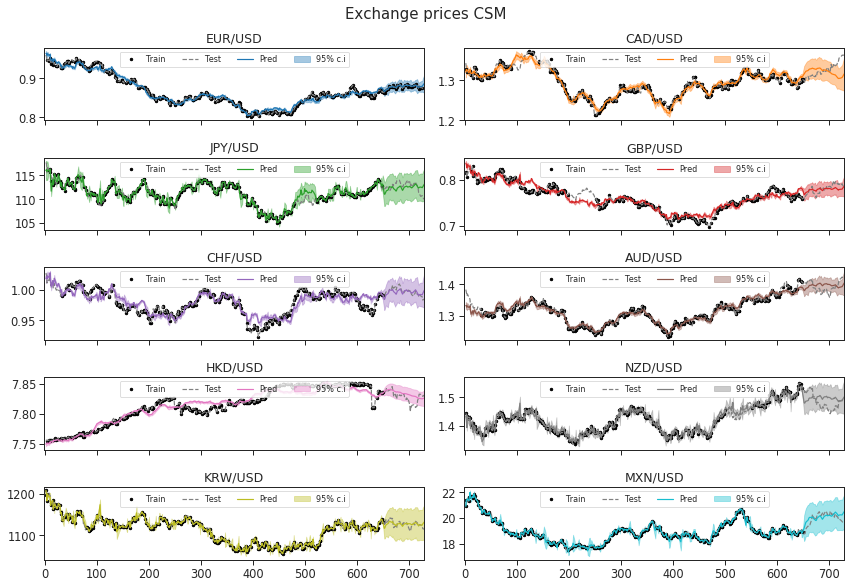

In [53]:
mogptk.plot_prediction(model_csm, grid=(5, 2), names=cols, title='Exchange prices CSM');

## SM-LMC

In [203]:
n_trials = 5

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_mape = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=5)
    model_smlmc.init_params('BNSE')
    
    model_smlmc.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_mape[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'MAPE%', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -5315.944677
  Number of iterations: 5000
  Number of functions evaluations: 5145
Done in  87.23378446896871  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -5301.761731
  Number of iterations: 5000
  Number of functions evaluations: 5183
Done in  87.89827206929525  minutes
Trial  2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -5264.240790
  Number of iterations: 5000
  Number of functions evaluations: 5197
Done in  88.00081321398417  minutes
Trial  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -5264.180728
  Number of iterations: 5000
  Number of functions evaluations: 5176


,MAE,MAPE%,RMSE,MAE std,MAPE% std,RMSE std
0,0.005515,0.632125,0.007245,0.000206,0.022368,0.000301
1,0.009014,0.687216,0.012454,0.000721,0.055143,0.000611
2,0.779562,0.700854,1.053464,0.057467,0.050163,0.065432
3,0.008503,1.111563,0.010830,0.000159,0.020656,0.000156
4,0.007610,0.776831,0.009909,0.000416,0.041634,0.000291
5,0.012842,0.949344,0.016352,0.000434,0.031854,0.000632
6,0.007609,0.097321,0.009487,0.000479,0.006127,0.000699
7,0.015225,1.051388,0.020371,0.001186,0.081195,0.001580
8,5.973333,0.532035,7.926659,0.616643,0.055201,0.850407
9,0.183073,0.935863,0.292084,0.041783,0.207585,0.064834


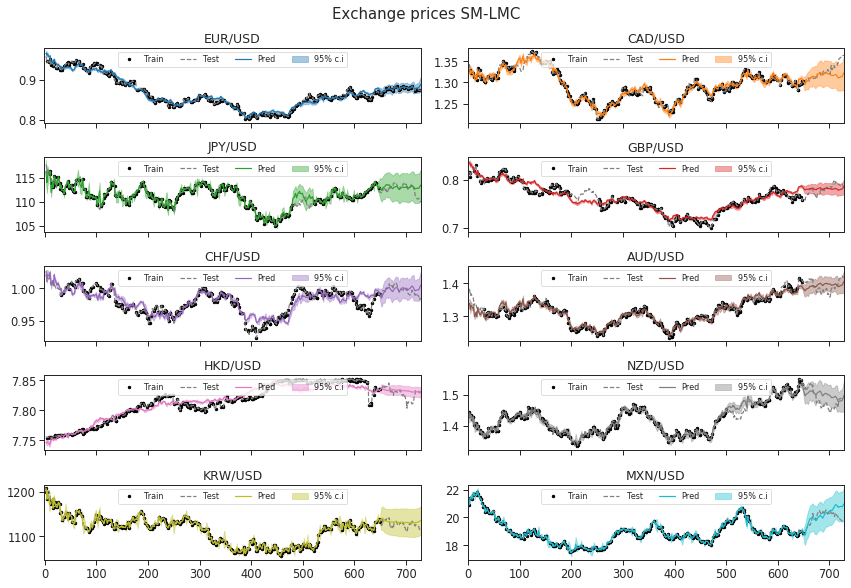

In [204]:
mogptk.plot_prediction(model_smlmc, grid=(5, 2), names=cols, title='Exchange prices SM-LMC');

## Compare All

In [205]:
print(mosm_mae[:, 1:].mean(), csm_mae[:, 1:].mean(), smlmc_mae[:, 1:].mean())

0.6603721836433272 0.6722302263722585 0.7774191002753731


In [218]:
print(mosm_mape[:, 1:].mean(), csm_mape[:, 1:].mean(), smlmc_mape[:, 1:].mean())

0.6215734729974687 0.7873562897272459 0.760268339140766


In [207]:
print(mosm_rmse[:, 1:].mean(), csm_rmse[:, 1:].mean(), smlmc_rmse[:, 1:].mean())

0.9306527740694119 0.9014364910481626 1.0390676733859894


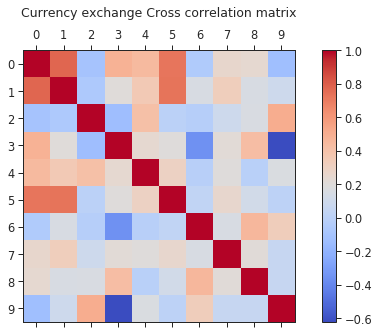

In [221]:
f, ax, corr_matrix = model_mosm.plot_correlations()
ax.set_title('Currency exchange Cross correlation matrix', pad=20)
ax.set_yticks(np.arange(10));
ax.set_xticks(np.arange(10));
plt.savefig('output/corr_currency.pdf', bbox_inches='tight')

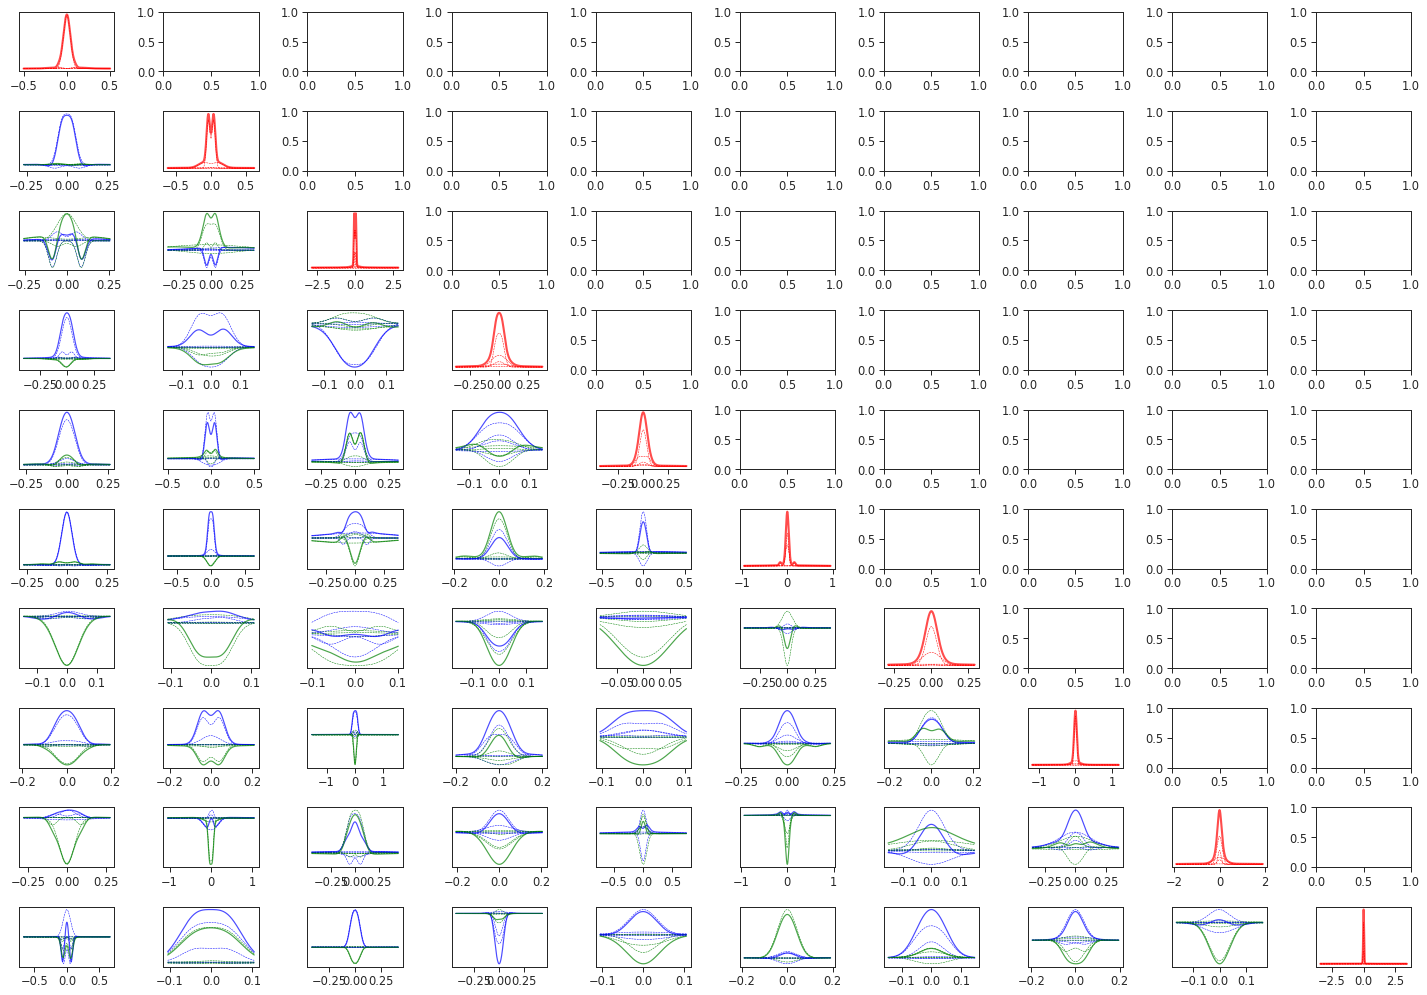

In [259]:
f, axarr = model_mosm.plot_psd()

## IGP
Independant gaussian process with spectral mixture kernel

Q = 4

x_pred = {i:array for i, array in enumerate(data.X_all)}

igp_mae = np.zeros((n_trials, len(cols)))
igp_mape = np.zeros((n_trials, len(cols)))
igp_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):    

    for i in range(len(cols)):
        # create data
        data_single = mogptk.Data()
        data_single.add(data.X[i], data.Y[i])
        
        model = mogptk.SM(data_single, Q=Q)
        model.init_params('BNSE')
        model.train(method='L-BFGS-B', maxiter=3000, tol=1e-15)
        
        idx = data.Y_all[i] != 0
        
        y_pred, var_pred = model.predict(x_pred)
        
        igp_mae[n, i] = np.abs(data.Y_all[i] - y_pred[0]).mean() # MAE
        igp_mape[n, i] = np.abs((data.Y_all[i][idx] - y_pred[0][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
        igp_mse[n, i] = ((data.Y_all[i] - y_pred[0])**2).mean() # MSE